# Install packages

In [1]:
# install.packages("devtools")
# install.packages("readr")
# install.packages("pheatmap")
# install.packages("tibble")
# install.packages("ggpubr")

# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("progeny")

# ## To install the new version until it is submitted to Bioconductor use:
# devtools::install_github("saezlab/progeny")

# install.packages('devtools')
# devtools::install_github('immunogenomics/presto')


# Set up environment

In [3]:
library(progeny)
library(dplyr)
library(Seurat)
library(ggplot2)
library(tidyr)
library(readr)
library(pheatmap)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




# Load data

In [4]:
seu <- readRDS("../output/seu_GSE184357_frozen.rds")
seu

An object of class Seurat 
32617 features across 3879 samples within 1 assay 
Active assay: RNA (32617 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, harmony

# Pathway activity per cell population

In [5]:
unique(seu$clinical_status)

[1] "primary"    "recurrence" NA

In [6]:
unique(seu$location)

[1] "thalamic" "pontine"  "spinal"

In [7]:
seu_pons <- subset(seu, subset= location == 'pontine')
seu_pons

seu_thalamic <- subset(seu, subset= location == 'thalamic')
seu_thalamic

seu_primary <- subset(seu, subset= clinical_status == 'primary')
seu_primary

seu_recurrence <- subset(seu, subset= clinical_status == 'recurrence')
seu_recurrence

An object of class Seurat 
32617 features across 1360 samples within 1 assay 
Active assay: RNA (32617 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, harmony

An object of class Seurat 
32617 features across 2380 samples within 1 assay 
Active assay: RNA (32617 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, harmony

Warning message:
“Removing 447 cells missing data for vars requested”


An object of class Seurat 
32617 features across 1997 samples within 1 assay 
Active assay: RNA (32617 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, harmony

Warning message:
“Removing 447 cells missing data for vars requested”


An object of class Seurat 
32617 features across 1435 samples within 1 assay 
Active assay: RNA (32617 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, harmony

[1] "scRNA for all locations:"
[1] "scRNA for pontine location only:"


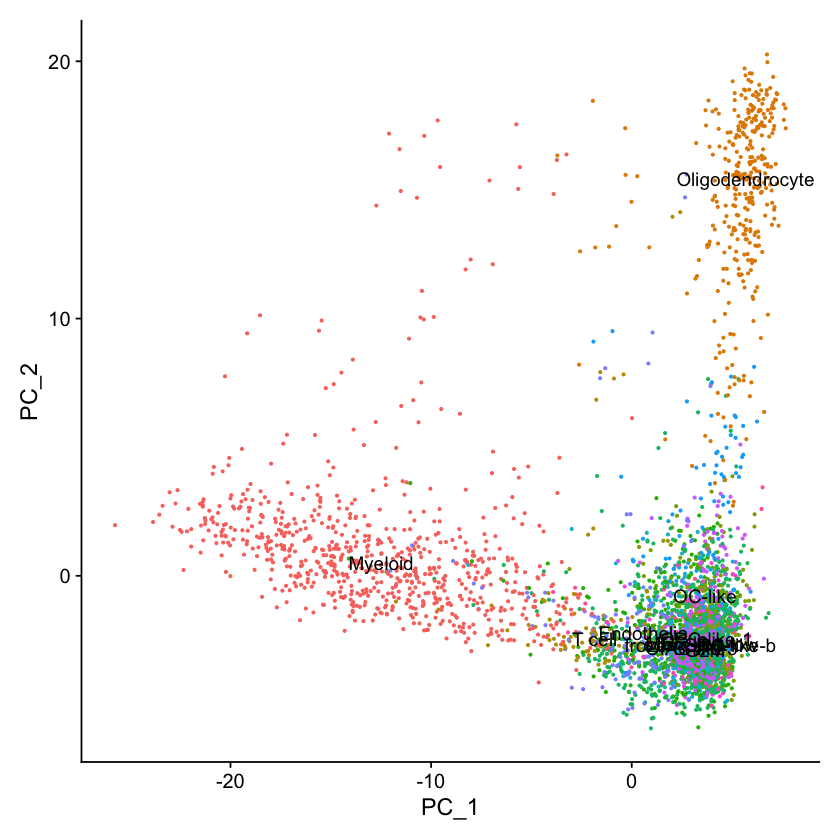

[1] "scRNA for thalamic location only:"


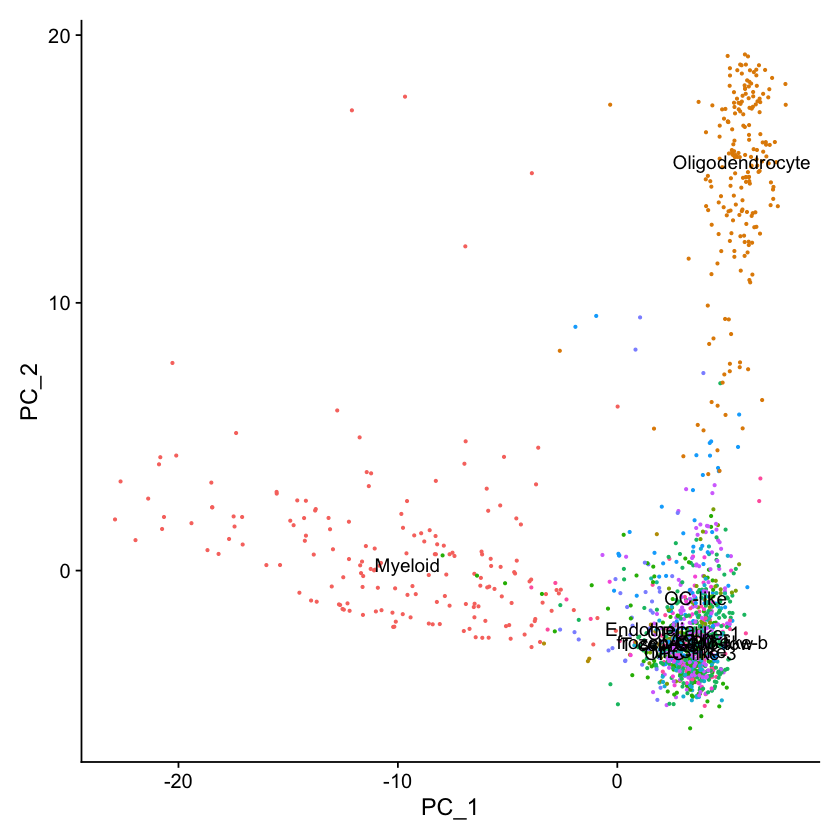

[1] "scRNA for primary only:"


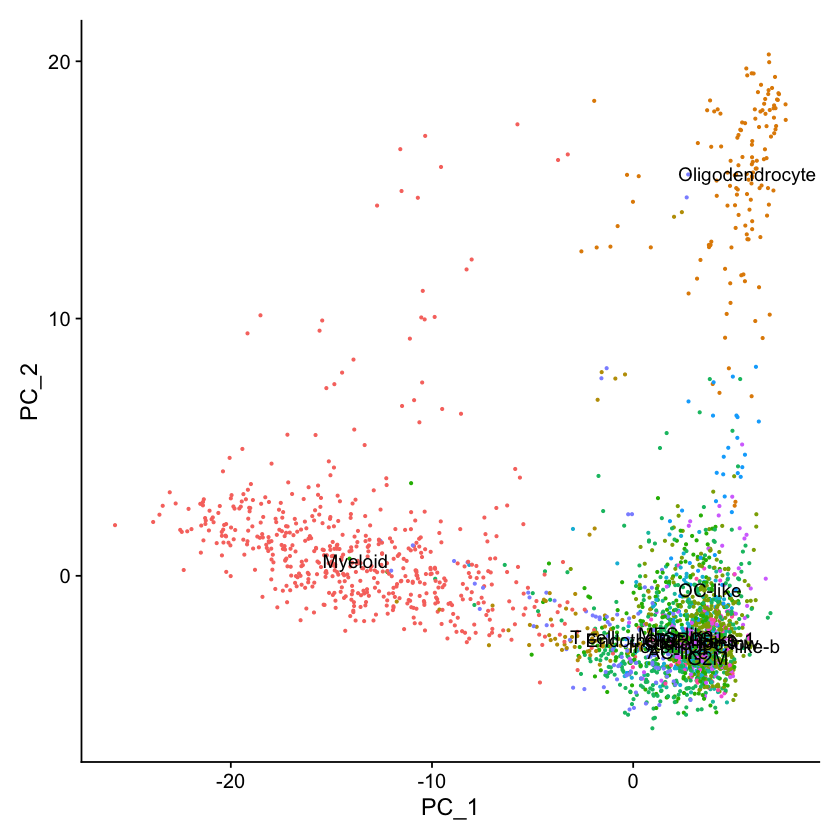

[1] "scRNA for recurrence only:"


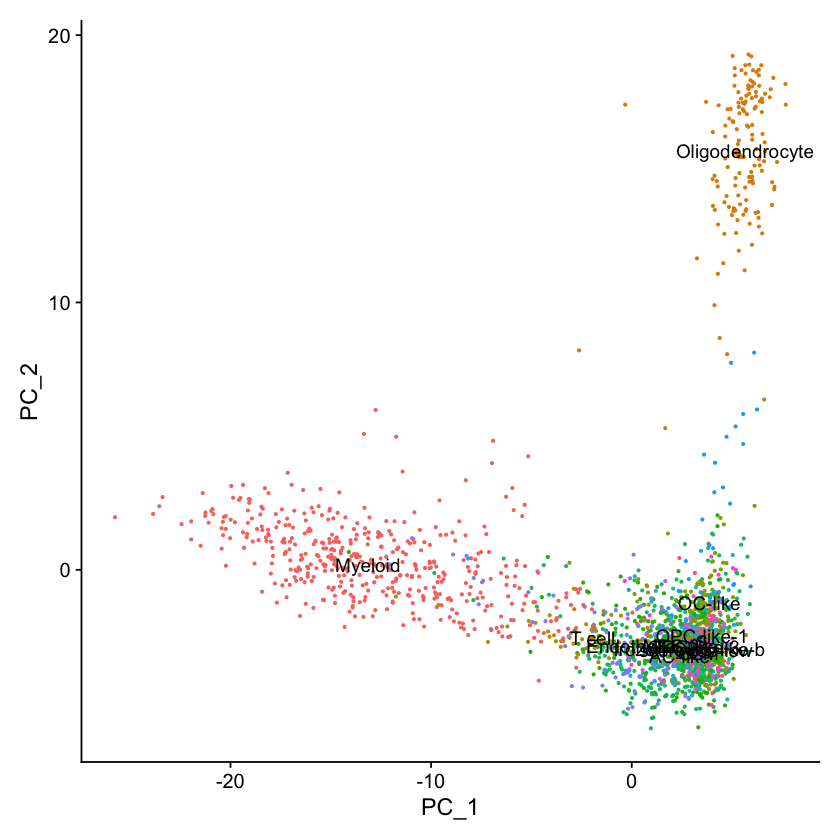

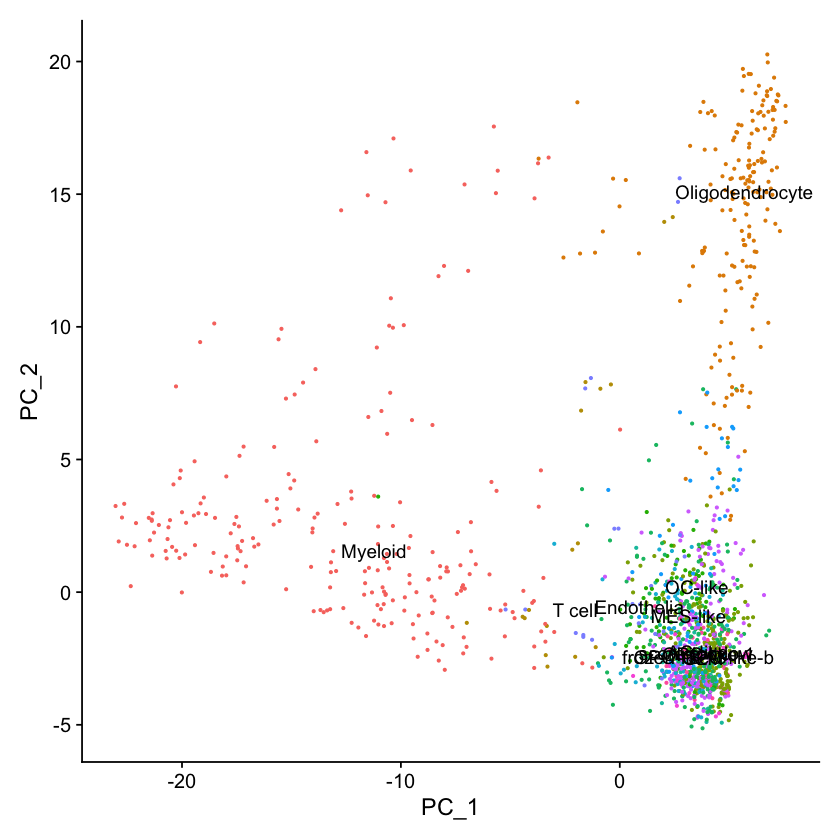

In [8]:
print("scRNA for all locations:")
DimPlot(seu, label = TRUE, pt.size = 0.5) + NoLegend()

print("scRNA for pontine location only:")
DimPlot(seu_pons, label = TRUE, pt.size = 0.5) + NoLegend()
print("scRNA for thalamic location only:")
DimPlot(seu_thalamic, label = TRUE, pt.size = 0.5) + NoLegend()

print("scRNA for primary only:")
DimPlot(seu_primary, label = TRUE, pt.size = 0.5) + NoLegend()
print("scRNA for recurrence only:")
DimPlot(seu_recurrence, label = TRUE, pt.size = 0.5) + NoLegend()

In [9]:
pathway_analysis <- function(seu){
    # Umap for the cell type label
    DimPlot(seu, label = TRUE, pt.size = 0.5) 

    # Assign the cluster name in dataframe
    CellsClusters <- data.frame(Cell = names(Idents(seu)), 
        CellType = as.character(Idents(seu)),
        stringsAsFactors = FALSE)

    ## Finally, we compute PROGENy pathway activity scores on the scRNA-seq data, and we then characterice the different cell populations based on these scores.
    ## We compute the Progeny activity scores and add them to our Seurat object as a new assay called Progeny. 
    seu.progeny <- progeny(seu, scale=FALSE, organism="Human", top=500, perm=1, 
        return_assay = TRUE)

    ## We can now directly apply Seurat functions in our Progeny scores. 
    ## For instance, we scale the pathway activity scores. 
    seu.progeny <- Seurat::ScaleData(seu.progeny, assay = "progeny") 

    ## We transform Progeny scores into a data frame to better handling the results
    progeny_scores_df <- 
        as.data.frame(t(GetAssayData(seu.progeny, slot = "scale.data", 
            assay = "progeny"))) %>%
        rownames_to_column("Cell") %>%
        gather(Pathway, Activity, -Cell) 

    ## We match Progeny scores with the cell clusters.
    progeny_scores_df <- inner_join(progeny_scores_df, CellsClusters)

    ## We summarize the Progeny scores by cellpopulation
    summarized_progeny_scores <- progeny_scores_df %>% 
        group_by(Pathway, CellType) %>%
        summarise(avg = mean(Activity), std = sd(Activity))

    ## We prepare the data for the plot
    summarized_progeny_scores_df <- summarized_progeny_scores %>%
        dplyr::select(-std) %>%   
        spread(Pathway, avg) %>%
        data.frame(row.names = 1, check.names = FALSE, stringsAsFactors = FALSE) 

    # We plot the different pathway activities for the different cell populations
    paletteLength = 100
    myColor = colorRampPalette(c("Darkblue", "white","red"))(paletteLength)

    progenyBreaks = c(seq(min(summarized_progeny_scores_df), 0, 
                        length.out=ceiling(paletteLength/2) + 1),
                    seq(max(summarized_progeny_scores_df)/paletteLength, 
                        max(summarized_progeny_scores_df), 
                        length.out=floor(paletteLength/2)))
                        
    progeny_hmap = pheatmap(t(summarized_progeny_scores_df[,-1]),fontsize=14, 
                            fontsize_row = 10, 
                            color=myColor, breaks = progenyBreaks, 
                            main = "PROGENy (500)", angle_col = 45,
                            treeheight_col = 0,  border_color = NA)
    return (progeny_scores_df)
}


[1] "pathway for all scRNA:"


Centering and scaling data matrix

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Joining with `by = join_by(Cell)`
`summarise()` has grouped output by 'Pathway'. You can override using the
`.groups` argument.


[1] "pathway for all pontine scRNA only:"


Centering and scaling data matrix

Joining with `by = join_by(Cell)`
`summarise()` has grouped output by 'Pathway'. You can override using the
`.groups` argument.


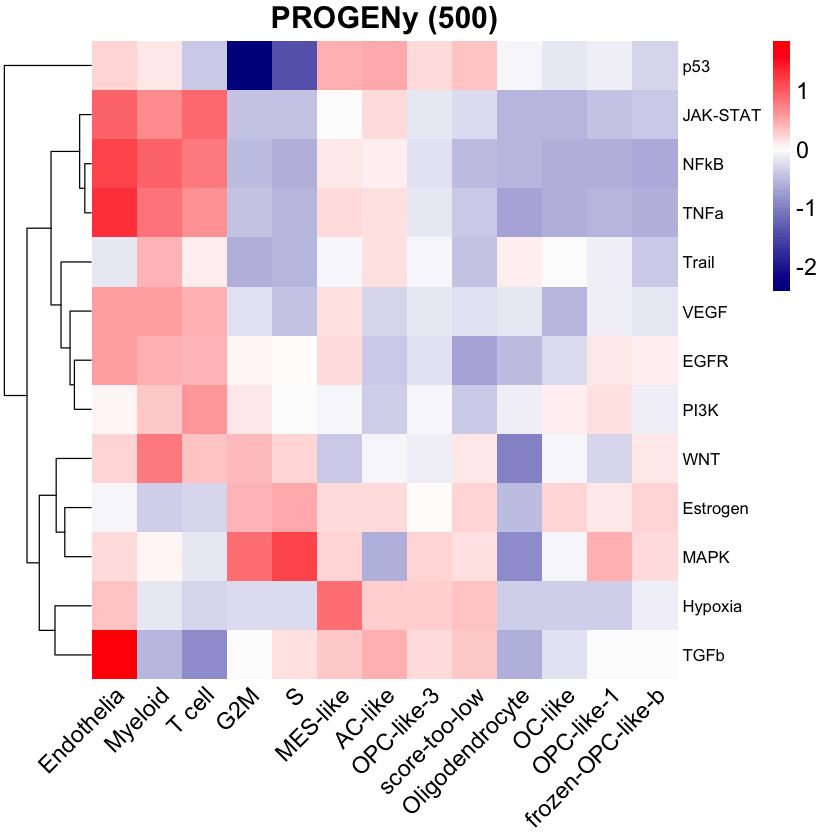

[1] "pathway for all thalamic scRNA only:"


Centering and scaling data matrix

Joining with `by = join_by(Cell)`
`summarise()` has grouped output by 'Pathway'. You can override using the
`.groups` argument.


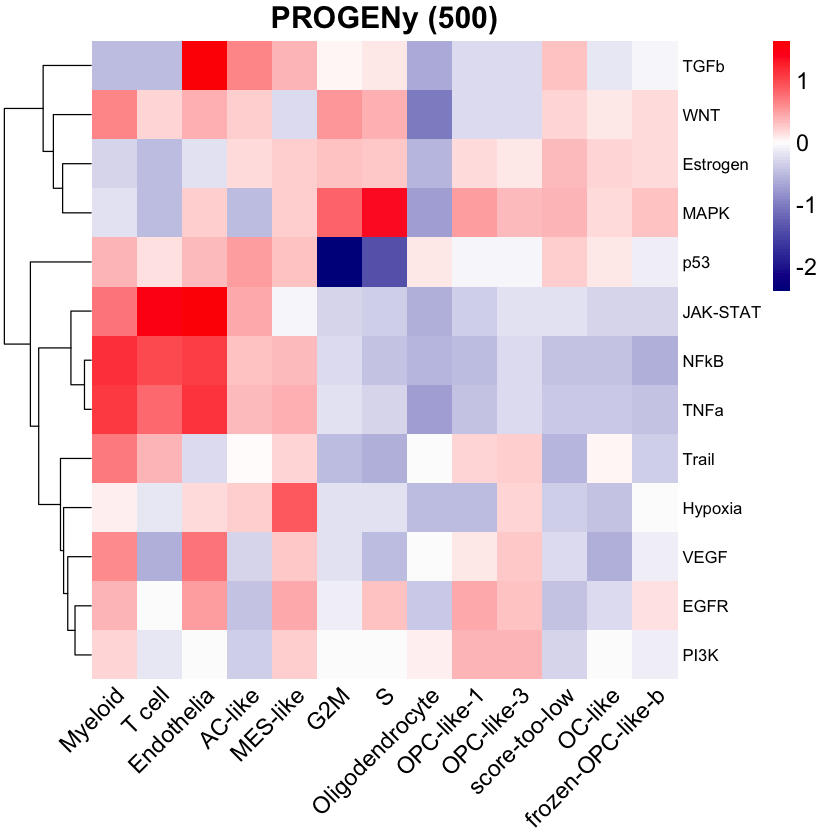

[1] "pathway for all seu_primary scRNA only:"


Centering and scaling data matrix

Joining with `by = join_by(Cell)`
`summarise()` has grouped output by 'Pathway'. You can override using the
`.groups` argument.


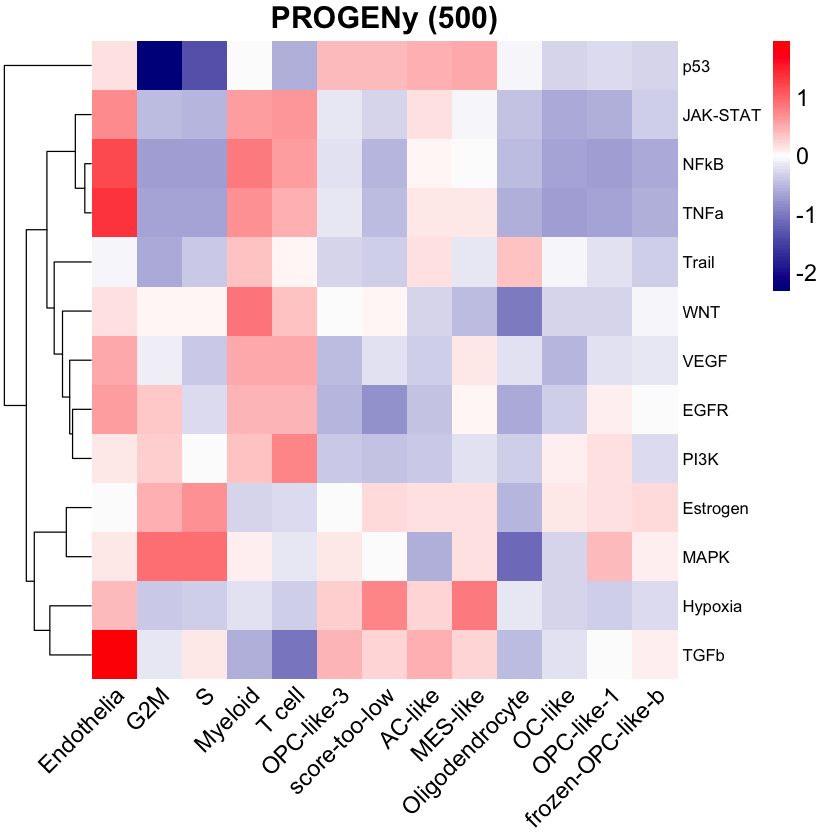

[1] "pathway for all recurrence scRNA only:"


Centering and scaling data matrix

Joining with `by = join_by(Cell)`
`summarise()` has grouped output by 'Pathway'. You can override using the
`.groups` argument.


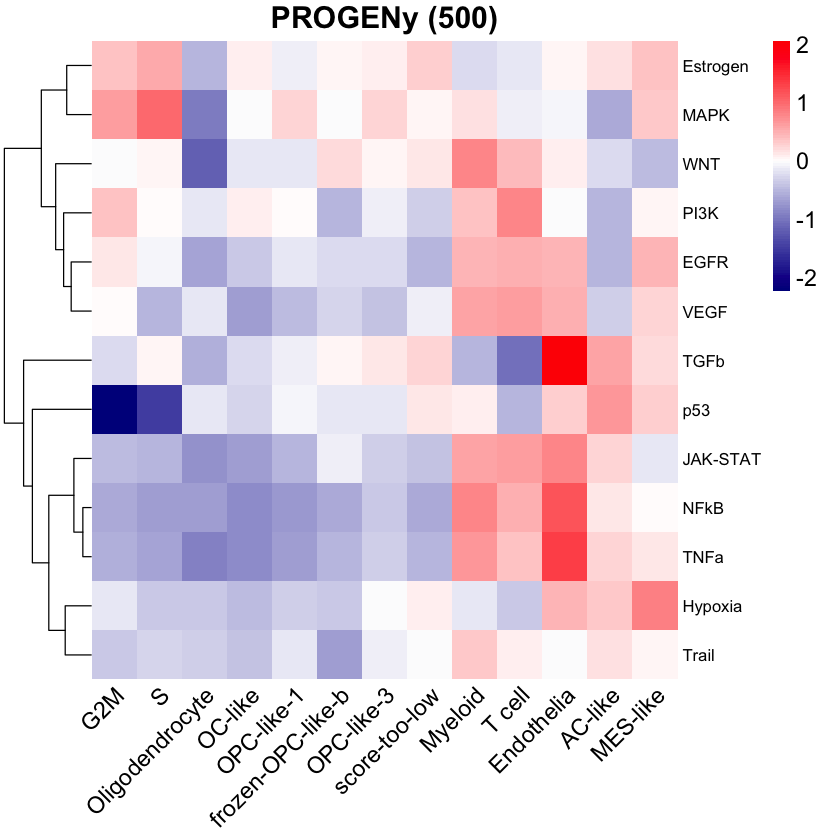

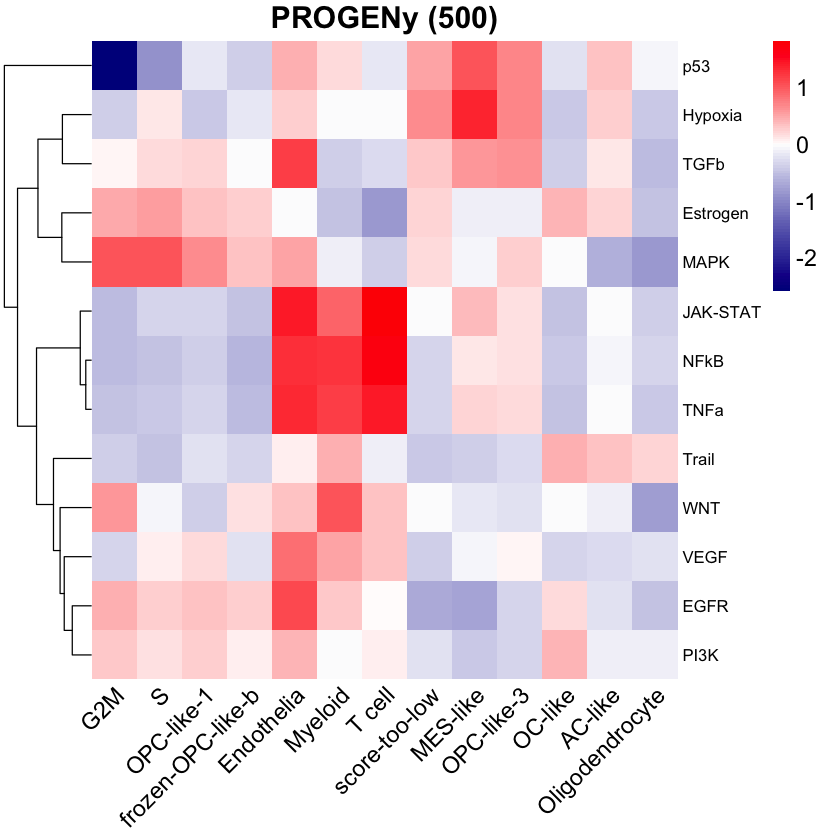

In [10]:
print("pathway for all scRNA:")
all_pathwayscore <- pathway_analysis(seu)

print("pathway for all pontine scRNA only:")
pons_pathwayscore <- pathway_analysis(seu_pons)
pons_pathwayscore$Condition <- 'pons'
print("pathway for all thalamic scRNA only:")
thalamic_pathwayscore <- pathway_analysis(seu_thalamic)
thalamic_pathwayscore$Condition <- 'thalamic'

print("pathway for all seu_primary scRNA only:")
primary_pathwayscore <- pathway_analysis(seu_primary)
primary_pathwayscore$Condition <- 'primary'
print("pathway for all recurrence scRNA only:")
recurrence_pathwayscore <- pathway_analysis(seu_recurrence)
recurrence_pathwayscore$Condition <- 'recurrence'


In [11]:
location_pathwayscore <- rbind(pons_pathwayscore, thalamic_pathwayscore)
clinic_status_pathwayscore <- rbind(primary_pathwayscore, recurrence_pathwayscore)


[1] "p-val is:  0.0582521785771543"


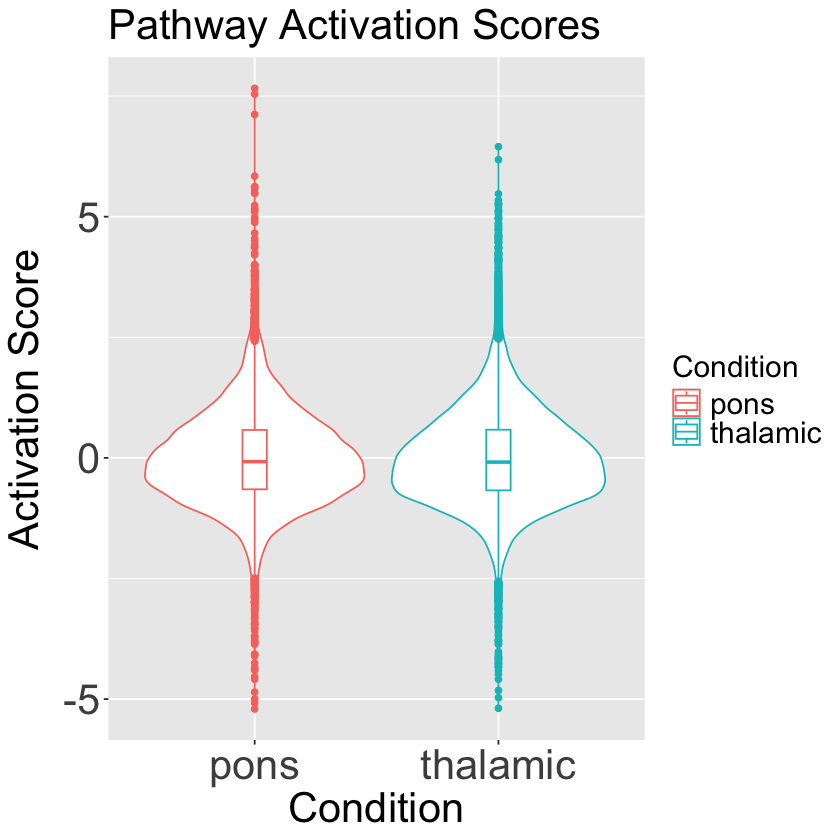

In [32]:
res <- ks.test(location_pathwayscore$Activity[location_pathwayscore$Condition=='pons'], location_pathwayscore$Activity[location_pathwayscore$Condition=='thalamic'])
p1 <- res$p
print(paste("p-val is: ", p1))
violin_plot <- ggplot(location_pathwayscore, aes(x = Condition, y = Activity, color = Condition) ) +
  geom_violin() +
  labs(title = "Pathway Activation Scores",
       x = "Condition",
       y = "Activation Score")+
       geom_boxplot(width=0.1)+
         theme(
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
        plot.title = element_text(size = 25),
        plot.subtitle = element_text(size = 25),
        axis.text=element_text(size=25),
        axis.title=element_text(size=25)
  )


print(violin_plot)

[1] "p-val is:  0.245675943565704"


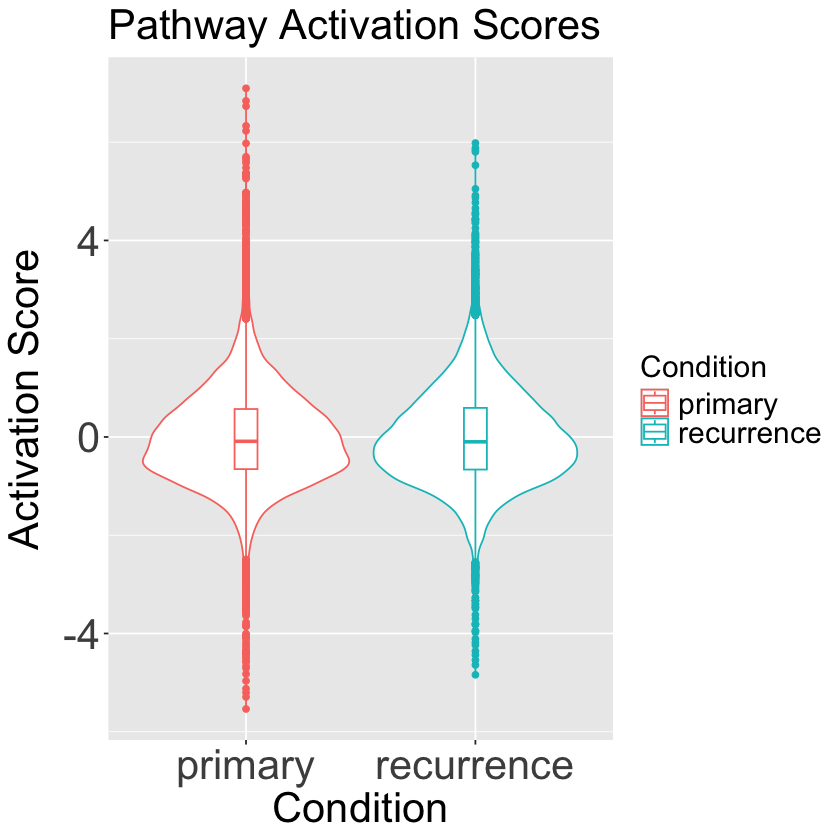

In [33]:
res <- ks.test(clinic_status_pathwayscore$Activity[clinic_status_pathwayscore$Condition=='primary'], clinic_status_pathwayscore$Activity[clinic_status_pathwayscore$Condition=='recurrence'])
p1 <- res$p
print(paste("p-val is: ", p1))
violin_plot <- ggplot(clinic_status_pathwayscore, aes(x = Condition, y = Activity, color = Condition) ) +
  geom_violin() +
  labs(title = "Pathway Activation Scores",
       x = "Condition",
       y = "Activation Score")+
       geom_boxplot(width=0.1)+
         theme(
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
        plot.title = element_text(size = 25),
        plot.subtitle = element_text(size = 25),
        axis.text=element_text(size=25),
        axis.title=element_text(size=25)
  )


print(violin_plot)